# Deep Learning for High Energy Particle Physics

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/amol/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/amol/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Reading in the Data

In [2]:
train = pd.read_csv('./all_train.csv.gz')

In [3]:
train.head()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
0,1.0,-0.346368,0.416306,0.999236,0.475342,0.427493,-0.005984,1.989833,0.344530,1.566297,...,4.105282,0.267826,0.378718,1.743123,3.406367,4.350537,-0.352571,1.130032,2.227706,1000.0
1,1.0,1.708236,-0.319394,-1.241873,-0.887231,-0.871906,-0.005984,-0.001047,-1.038225,0.655748,...,-1.178141,-0.877361,-1.483769,-0.573682,-1.693781,-0.545062,-0.299118,-0.662942,-0.193019,750.0
2,0.0,-0.360693,1.794174,0.264738,-0.472273,-0.292344,-1.054221,-1.150495,1.423404,1.270098,...,-1.199511,0.539020,-1.590629,-0.573682,-0.543636,-0.937456,-0.300344,-0.523262,-1.506304,750.0
3,1.0,-0.377914,-0.103932,-0.649434,-2.125015,-1.643797,-0.005984,1.011112,-1.040340,-0.541991,...,0.463763,-0.006583,1.089122,-0.573682,-0.276348,-0.409272,-0.349926,-0.307123,0.529698,1250.0
4,0.0,-0.067436,-0.636762,-0.620166,-0.062551,1.588715,-0.005984,-0.595304,-1.238987,0.336844,...,-0.552837,-1.418494,-0.562982,1.743123,0.881802,0.002516,1.560950,-0.150760,-1.023889,750.0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000000 entries, 0 to 6999999
Data columns (total 29 columns):
 #   Column   Dtype  
---  ------   -----  
 0   # label  float64
 1   f0       float64
 2   f1       float64
 3   f2       float64
 4   f3       float64
 5   f4       float64
 6   f5       float64
 7   f6       float64
 8   f7       float64
 9   f8       float64
 10  f9       float64
 11  f10      float64
 12  f11      float64
 13  f12      float64
 14  f13      float64
 15  f14      float64
 16  f15      float64
 17  f16      float64
 18  f17      float64
 19  f18      float64
 20  f19      float64
 21  f20      float64
 22  f21      float64
 23  f22      float64
 24  f23      float64
 25  f24      float64
 26  f25      float64
 27  f26      float64
 28  mass     float64
dtypes: float64(29)
memory usage: 1.5 GB


## Exploratory Data Analysis

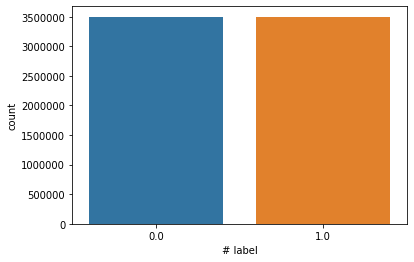

In [4]:
sns.countplot(train['# label'])

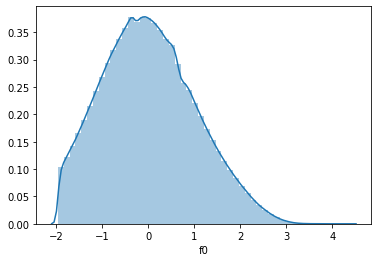

In [15]:
sns.distplot(train['f0'])

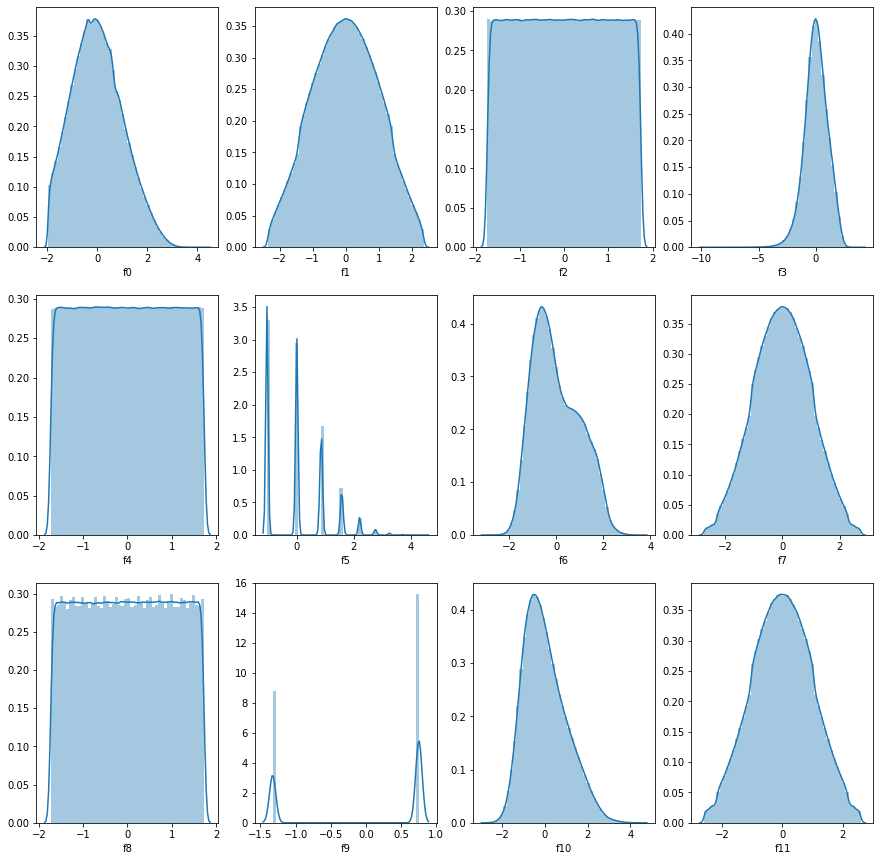

In [33]:
cols = 4
fig, axes = plt.subplots(ncols=cols, nrows=3, sharey=False, figsize=(15,15))

for i in range(12):
    feature = 'f{}'.format(i)
    col = i % cols
    row = i // cols
    sns.distplot(train[feature], ax=axes[row][col])

## Data Preprocessing

### Scaling Mass

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train['mass'] = scaler.fit_transform(train['mass'].values.reshape(-1, 1))

In [5]:
X = train.drop(['# label'], axis=1)
y = train['# label']

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000000 entries, 0 to 6999999
Data columns (total 28 columns):
 #   Column  Dtype  
---  ------  -----  
 0   f0      float64
 1   f1      float64
 2   f2      float64
 3   f3      float64
 4   f4      float64
 5   f5      float64
 6   f6      float64
 7   f7      float64
 8   f8      float64
 9   f9      float64
 10  f10     float64
 11  f11     float64
 12  f12     float64
 13  f13     float64
 14  f14     float64
 15  f15     float64
 16  f16     float64
 17  f17     float64
 18  f18     float64
 19  f19     float64
 20  f20     float64
 21  f21     float64
 22  f22     float64
 23  f23     float64
 24  f24     float64
 25  f25     float64
 26  f26     float64
 27  mass    float64
dtypes: float64(28)
memory usage: 1.5 GB


### Training and Validation Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

## Training Deep Neural Networks in Keras

### Defining the Neural Network

In [8]:
from keras.regularizers import l2 # L2 regularization
from keras.callbacks import *
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from kerastuner import Hyperband

n_features = X.values.shape[1]

def build_model(hp):
    
    hp_n_layers = hp.Int('units', min_value = 28, max_value = 112, step = 28)
    model = Sequential()
    model.add(Dense(hp_n_layers, input_dim=n_features, activation='relu'))
    model.add(Dense(hp_n_layers, activation='relu'))
    model.add(Dense(hp_n_layers, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    # Compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=hp_learning_rate), 
                  metrics=['accuracy'])
    return model


tuner = Hyperband(build_model,
                  objective = 'val_accuracy', 
                  max_epochs = 10,
                  factor = 3,
                  directory = 'hyperparameters',
                  project_name = 'hepmass_deep_learning')

INFO:tensorflow:Reloading Oracle from existing project hyperparameters/hepmass_deep_learning/oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameters/hepmass_deep_learning/tuner0.json


### Hyperparameter Tuning

In [9]:
import IPython

class ClearTrainingOutput(Callback):
    
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [10]:
tuner.search(X_train, y_train, epochs=10, 
             validation_data = (X_valid, y_valid), 
             callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Optimal hidden layer size: {best_hps.get('units')} \n
optimal learning rate: {best_hps.get('learning_rate')}.""")

INFO:tensorflow:Oracle triggered exit

Optimal hidden layer size: 112 

optimal learning rate: 0.001.


In [11]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=4, validation_data = (X_valid, y_valid))

Epoch 1/4
153125/153125 [==============================] - 150s 973us/step - loss: 0.2859 - accuracy: 0.8691 - val_loss: 0.2684 - val_accuracy: 0.8788
Epoch 2/4
153125/153125 [==============================] - 151s 984us/step - loss: 0.2688 - accuracy: 0.8788 - val_loss: 0.2660 - val_accuracy: 0.8799
Epoch 3/4
153125/153125 [==============================] - 181s 1ms/step - loss: 0.2660 - accuracy: 0.8801 - val_loss: 0.2645 - val_accuracy: 0.8809
Epoch 4/4
153125/153125 [==============================] - 148s 969us/step - loss: 0.2655 - accuracy: 0.8806 - val_loss: 0.2655 - val_accuracy: 0.8816


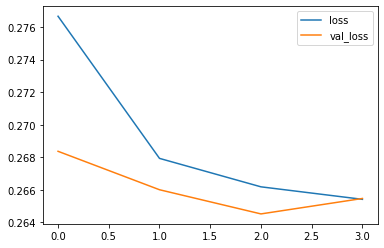

In [22]:
pd.DataFrame(history.history).plot(y=['loss', 'val_loss'])

## Evaluating the Model on the Testing Data

In [23]:
test = pd.read_csv('./all_test.csv.gz')
test['mass'] = scaler.fit_transform(test['mass'].values.reshape(-1, 1))

In [24]:
X = test.drop(['# label'], axis=1)
y = test['# label']

In [25]:
model.evaluate(X, y)

109375/109375 [==============================] - 60s 544us/step - loss: 0.2666 - accuracy: 0.8808


[0.26661229133605957, 0.8807885646820068]